# Sample Collection + Data Preparation 

## Import libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error as mse
from fredapi import Fred
sns.set()

## Get data from FRED API

In [3]:
fred = Fred(api_key='c9bf6c761c1df3965ce56d77ef6c8f77')

df = {}
df['gdp'] = fred.get_series('GDP') #1947-2021, quarterly
df['gnp'] = fred.get_series('GNP') #1947-2021, quarterly
df['real_gdp'] = fred.get_series('GDPC1') #1947-2021, quarterly
df['real_gdp_per_capita'] = fred.get_series('A939RX0Q048SBEA') #1947-2021, quarterly
df['net_exports'] = fred.get_series('NETEXP') #1947-2021, quarterly
df['gni'] = (df['gdp'] + df['net_exports'])
df['govt_spending'] = fred.get_series('GCEC1') #1947-2021, quarterly
df['consumer_spending'] = fred.get_series('PCEC') #1947-2021, quarterly
df['private_domestic_investment'] = fred.get_series('Y006RC1Q027SBEA') #1947-2021, quarterly
df['cpi'] = fred.get_series('CPIAUCSL', frequency='q', aggregation_method='avg') #1947-2022, quarterly
df['consumer_oil_price'] = fred.get_series('CUSR0000SEHE', frequency='q', aggregation_method='avg') #1947-2022, quarterly
df['ir'] = fred.get_series('INTDSRUSM193N', frequency='q', aggregation_method='avg') #1950-2021, quarterly
df['unemployment_rate'] = fred.get_series('UNRATE', frequency='q', aggregation_method='avg') #1948-2022, quarterly

df = pd.DataFrame(df)
df_clean= df.dropna() 
df_clean

,gdp,gnp,real_gdp,real_gdp_per_capita,net_exports,gni,govt_spending,consumer_spending,private_domestic_investment,cpi,consumer_oil_price,ir,unemployment_rate
1950-01-01,280.828,282.056,2186.365,14500.0,2.203,283.031,599.569,182.920,1.071,23.587,11.033,1.50,6.4
1950-04-01,290.383,291.699,2253.045,14889.0,1.643,292.026,610.519,186.806,1.164,23.767,11.133,1.50,5.6
1950-07-01,308.153,309.760,2340.112,15398.0,-0.740,307.413,600.663,200.505,1.247,24.203,11.267,1.61,4.6
1950-10-01,319.945,321.554,2384.920,15623.0,-0.154,319.791,643.100,197.946,1.289,24.693,11.500,1.75,4.2
1951-01-01,336.000,337.537,2417.311,15769.0,0.177,336.177,711.537,209.207,1.296,25.697,11.700,1.75,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01,19477.444,19649.442,17258.205,52031.0,-538.876,18938.568,3378.132,12989.729,519.850,256.418,219.570,0.25,13.0
2020-07-01,21138.574,21365.412,18560.774,55933.0,-725.723,20412.851,3360.238,14293.832,539.864,259.438,232.403,0.25,8.8
2020-10-01,21477.597,21728.223,18767.778,56533.0,-798.431,20679.166,3356.030,14467.611,561.269,260.879,234.862,0.25,6.8
2021-01-01,22038.226,22273.060,19055.655,57405.0,-872.540,21165.686,3390.921,15005.444,576.340,263.525,274.983,0.25,6.2


## Import SPX Data from CSV file

In [26]:
SPX = pd.read_csv("SPX.csv") #1950-2022, monthly
SPX['Date'] = pd.to_datetime(SPX['Date'], format='%d/%m/%Y')
SPX.set_index("Date", inplace=True)
SPX = SPX.resample("Q", convention='start', origin='start').mean()
SPX.index = SPX.index + pd.offsets.MonthBegin(1)
SPX['ClosePrev'] = SPX['Close'].shift(periods=1)
SPX['CloseNext'] = SPX['Close'].shift(periods=-1)
SPX = SPX.drop(['Open','High','Low'], axis=1)
SPX

,Close,Volume,ClosePrev,CloseNext
Date,,,,
1950-04-01,17.186667,2.371296e+07,NaN,18.180000
1950-07-01,18.180000,2.760741e+07,17.186667,18.570000
1950-10-01,18.570000,2.260370e+07,18.180000,19.816667
1951-01-01,19.816667,3.068148e+07,18.570000,21.620000
1951-04-01,21.620000,3.020555e+07,19.816667,21.636667
...,...,...,...,...
2021-04-01,3832.760000,5.277860e+10,3549.220000,4227.593333
2021-07-01,4227.593333,4.502311e+10,3832.760000,4408.493333
2021-10-01,4408.493333,4.207726e+10,4227.593333,4646.186667


In [51]:
df_full = pd.concat([df_clean,SPX], axis=1)
df_full = df_full.dropna()
df_full

,gdp,gnp,real_gdp,real_gdp_per_capita,net_exports,gni,govt_spending,consumer_spending,private_domestic_investment,cpi,consumer_oil_price,ir,unemployment_rate,Close,Volume,ClosePrev,CloseNext
1950-07-01,308.153,309.760,2340.112,15398.0,-0.740,307.413,600.663,200.505,1.247,24.203,11.267,1.61,4.6,18.180000,2.760741e+07,17.186667,18.570000
1950-10-01,319.945,321.554,2384.920,15623.0,-0.154,319.791,643.100,197.946,1.289,24.693,11.500,1.75,4.2,18.570000,2.260370e+07,18.180000,19.816667
1951-01-01,336.000,337.537,2417.311,15769.0,0.177,336.177,711.537,209.207,1.296,25.697,11.700,1.75,3.5,19.816667,3.068148e+07,18.570000,21.620000
1951-04-01,344.090,345.973,2459.196,15979.0,1.943,346.033,806.376,204.942,1.332,25.947,11.933,1.75,3.1,21.620000,3.020555e+07,19.816667,21.636667
1951-07-01,351.385,353.381,2509.880,16234.0,3.742,355.127,895.015,207.616,1.385,25.933,11.933,1.75,3.2,21.636667,2.172778e+07,21.620000,22.980000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01,19477.444,19649.442,17258.205,52031.0,-538.876,18938.568,3378.132,12989.729,519.850,256.418,219.570,0.25,13.0,2921.443333,5.985144e+10,3136.440000,3019.010000
2020-07-01,21138.574,21365.412,18560.774,55933.0,-725.723,20412.851,3360.238,14293.832,539.864,259.438,232.403,0.25,8.8,3019.010000,6.714349e+10,2921.443333,3378.143333
2020-10-01,21477.597,21728.223,18767.778,56533.0,-798.431,20679.166,3356.030,14467.611,561.269,260.879,234.862,0.25,6.8,3378.143333,5.204018e+10,3019.010000,3549.220000
2021-01-01,22038.226,22273.060,19055.655,57405.0,-872.540,21165.686,3390.921,15005.444,576.340,263.525,274.983,0.25,6.2,3549.220000,5.152288e+10,3378.143333,3832.760000


In [7]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=SPX.index, y=SPX["Close"], name="Close"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=SPX.index, y=SPX["Volume"], name="Volume"),
    secondary_y=True,
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Close</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Volume</b>", secondary_y=True)

fig.show()

## Create Multi-Step LSTM Model

In [8]:
TimeSteps = 10  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps = 1 # How many days in future you want to predict the prices

price = SPX[['Close']].values

# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import MinMaxScaler
 
# Standardise or normalise data so it better fits into model
#sc = StandardScaler()
sc = MinMaxScaler()
DataScaler = sc.fit(price)
X = DataScaler.transform(price)
X = X.reshape(X.shape[0],)

# split into samples
X_samples = list()
y_samples = list()
NumerOfRows = len(X)
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################
 
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data = np.array(X_samples)
X_data = X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
# Don't reshape y as a 3D data as it is supposed to be a single column only
y_data = np.array(y_samples)


# Choosing the number of testing data records
TestingRecords = 5
# Splitting the data into train and test
X_train = X_data[:-TestingRecords]
X_test = X_data[-TestingRecords:]
y_train = y_data[:-TestingRecords]
y_test = y_data[-TestingRecords:]

# Defining Input shapes for LSTM
TimeSteps = X_train.shape[1]
TotalFeatures = X_train.shape[2]


# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

###################################################################

import time
# Measuring the time taken by the model to train
StartTime = time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime = time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
55/55 [==============================] - 2s 6ms/step - loss: 0.0334
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0168
Epoch 3/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 4/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 5/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 6/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 7/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 8/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 9/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 10/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 11/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 12/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 13/100
55/55 [=================

## Test Model's Accuracy

In [9]:
df_temp = []
for i in range(10,284):
    end = i # 284 rows, so max end = 284-(no. of days predicting ahead)

    # Reshaping the data to (-1,1) because its a single entry
    LastNDaysPrices = df_full[['Close']][end-TimeSteps:end].values # [273:283]
    LastNDaysPrices = LastNDaysPrices.reshape(-1, 1)

    Original = (range(FutureTimeSteps), df_full.iloc[end:end+FutureTimeSteps, :]['Close'])[1].values

    # Scaling the data on the same level on which model was trained
    X_test = DataScaler.transform(LastNDaysPrices)

    NumberofSamples = 1
    TimeSteps = X_test.shape[0]
    NumberofFeatures = X_test.shape[1]

    # Reshaping the data as 3D input
    X_test = X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)

    # Generating the predictions for next 5 days
    Prediction = regressor.predict(X_test)
    Prediction = DataScaler.inverse_transform(Prediction)
    Prediction = Prediction[0]
    df_temp.append(Prediction)

dfT = pd.DataFrame(df_temp)
dfT.index += 10

df_full_temp = df_full.copy()
df_full_temp = df_full_temp.reset_index()

df_new = pd.concat([df_full_temp,dfT],axis=1)
df_new = df_new.shift(-10)
df_new = df_new.dropna()
df_new.rename(columns={0:'PredictedClose'}, inplace=True)

df_new['Diff'] = df_new['Close'] - df_new['PredictedClose']
df_new['%Diff'] = ((df_new['Close'] - df_new['PredictedClose']) / df_new['Close']) * 100

In [10]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=SPX.index,
    y=SPX["Close"],
    name="Actual Price"
))


fig.add_trace(go.Scatter(
    x=df_new["index"],
    y=df_new["Diff"],
    name="Absolute Error",
    yaxis="y2"
))

fig.add_trace(go.Scatter(
    x=df_new["index"],
    y=df_new["%Diff"],
    name="Percentage Error",
    yaxis="y3"
))

fig.add_trace(go.Scatter(
    x=df_new["index"],
    y=df_new["PredictedClose"],
    name="Predicted Price",
    yaxis="y1"
))


# Create axis objects
fig.update_layout(
    xaxis=dict(
        domain=[0.3, 0.7]
    ),
    yaxis=dict(
        title="<b>Price</b>",
        titlefont=dict(
            color="#1f77b4"
        ),
        tickfont=dict(
            color="#1f77b4"
        )
    ),
    yaxis2=dict(
        title="<b>Absolute</b> Error",
        titlefont=dict(
            color="#ff7f0e"
        ),
        tickfont=dict(
            color="#ff7f0e"
        ),
        anchor="free",
        overlaying="y",
        side="left",
        position=0.15
    ),
    yaxis3=dict(
        title="<b>Percentage</b> Error (%)",
        titlefont=dict(
            color="#d62728"
        ),
        tickfont=dict(
            color="#d62728"
        ),
        anchor="x",
        overlaying="y",
        side="right"
    )
)
#round((100 - (100*(abs(df_new["Close"]-df_new["PredictedClose2"])/df_new["Close"])).mean()),2)

# Update layout properties
fig.update_layout(
    title_text='### Accuracy of the predictions: ' + str(round((100 - (100*(abs(df_new["Close"]-df_new["PredictedClose"])/df_new["Close"])).mean()),2)) + '% | Mean Square Error: ' + str(mse(df_new["Close"], df_new["PredictedClose"]).round(2)) + ' ###',
    width = 2000,
)

fig.show()

## Calculate Model's Average Accuracy

In [11]:
res_df = pd.DataFrame({'MSE':[]})

for j in range(20):
    print(f"\nTRIAL {j+1}\n")
    TimeSteps = 10  # next few day's Price Prediction is based on last how many past day's prices
    FutureTimeSteps = 1 # How many days in future you want to predict the prices

    price = SPX[['Close']].values

    # Feature Scaling for fast training of neural networks
    from sklearn.preprocessing import MinMaxScaler

    # Standardise or normalise data so it better fits into model
    #sc = StandardScaler()
    sc = MinMaxScaler()
    DataScaler = sc.fit(price)
    X = DataScaler.transform(price)
    X = X.reshape(X.shape[0],)

    # split into samples
    X_samples = list()
    y_samples = list()
    NumerOfRows = len(X)

    # Iterate thru the values to create combinations
    for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
        x_sample = X[i-TimeSteps:i]
        y_sample = X[i:i+FutureTimeSteps]
        X_samples.append(x_sample)
        y_samples.append(y_sample)

    ################################################

    # Reshape the Input as a 3D (samples, Time Steps, Features)
    X_data = np.array(X_samples)
    X_data = X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
    # Don't reshape y as a 3D data  as it is supposed to be a single column only
    y_data = np.array(y_samples)


    # Choosing the number of testing data records
    TestingRecords = 5
    # Splitting the data into train and test
    X_train = X_data[:-TestingRecords]
    X_test = X_data[-TestingRecords:]
    y_train = y_data[:-TestingRecords]
    y_test = y_data[-TestingRecords:]

    # Defining Input shapes for LSTM
    TimeSteps = X_train.shape[1]
    TotalFeatures = X_train.shape[2]


    # Importing the Keras libraries and packages
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM

    # Initialising the RNN
    regressor = Sequential()

    # Adding the First input hidden layer and the LSTM layer
    # return_sequences = True, means the output of every time step to be shared with hidden next layer
    regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


    # Adding the Second hidden layer and the LSTM layer
    regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

    # Adding the Third hidden layer and the LSTM layer
    regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


    # Adding the output layer
    # Notice the number of neurons in the dense layer is now the number of future time steps 
    # Based on the number of future days we want to predict
    regressor.add(Dense(units = FutureTimeSteps))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    ###################################################################

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

    df_temp = pd.DataFrame({'Prediction':[]})
    for i in range(10,len(df_full['Close'])):
        end = i # 284 rows, so max end = 284-(no. of days predicting ahead)

        # Reshaping the data to (-1,1) because its a single entry
        LastNDaysPrices = df_full[['Close']][end-TimeSteps:end].values # [273:283]
        LastNDaysPrices = LastNDaysPrices.reshape(-1, 1)

        Original = (range(FutureTimeSteps), df_full.iloc[end:end+FutureTimeSteps, :]['Close'])[1].values

        # Scaling the data on the same level on which model was trained
        X_test = DataScaler.transform(LastNDaysPrices)

        NumberofSamples = 1
        TimeSteps = X_test.shape[0]
        NumberofFeatures = X_test.shape[1]

        # Reshaping the data as 3D input
        X_test = X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)

        # Generating the predictions for next 5 days
        Prediction = regressor.predict(X_test)
        Prediction = DataScaler.inverse_transform(Prediction)
        new_pred = {'Prediction':Prediction[0][0]}
        df_temp = df_temp.append(new_pred, ignore_index=True)
    
    new_row = {'MSE':mse(df_full["Close"][10:], df_temp["Prediction"])}
    res_df = res_df.append(new_row, ignore_index=True)
    
    display(res_df)
    


TRIAL 1

Epoch 1/100
55/55 [==============================] - 2s 7ms/step - loss: 0.0416
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0304
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0189
Epoch 4/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 5/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 7/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 8/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 9/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 10/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 11/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 12/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 13/100
55/55 [=======

,MSE
0,17233.778865



TRIAL 2

Epoch 1/100
55/55 [==============================] - 3s 7ms/step - loss: 0.0371
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0230
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 4/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 5/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 6/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 7/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 8/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 9/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 10/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 11/100
55/55 [==============================] - 0s 7ms/step - loss: 9.5583e-04
Epoch 12/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 13/100
55/55 [===

,MSE
0,17233.778865
1,7577.730156



TRIAL 3

Epoch 1/100
55/55 [==============================] - 3s 7ms/step - loss: 0.0278
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 4/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 5/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 6/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 7/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 8/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 9/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 10/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 11/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 12/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 13/100
55/55 [=======

,MSE
0,17233.778865
1,7577.730156
2,13687.982511



TRIAL 4

Epoch 1/100
55/55 [==============================] - 2s 7ms/step - loss: 0.0255
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0102
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 4/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0024
Epoch 5/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 6/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 7/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 8/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 9/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 10/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 11/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 12/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 13/100
55/55 [=======

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797



TRIAL 5

Epoch 1/100
55/55 [==============================] - 3s 8ms/step - loss: 0.0349
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0099
Epoch 3/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 4/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 5/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 6/100
55/55 [==============================] - 0s 8ms/step - loss: 9.2476e-04
Epoch 7/100
55/55 [==============================] - 0s 9ms/step - loss: 9.2716e-04
Epoch 8/100
55/55 [==============================] - 0s 9ms/step - loss: 8.9379e-04
Epoch 9/100
55/55 [==============================] - 0s 9ms/step - loss: 8.6145e-04
Epoch 10/100
55/55 [==============================] - 0s 8ms/step - loss: 8.0114e-04
Epoch 11/100
55/55 [==============================] - 0s 8ms/step - loss: 7.9674e-04
Epoch 12/100
55/55 [==============================] - 0s 8ms/step - loss: 7.1110e-04

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554



TRIAL 6

Epoch 1/100
55/55 [==============================] - 3s 8ms/step - loss: 0.0299
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0154
Epoch 3/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0037
Epoch 4/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 5/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 6/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 7/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 8/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 9/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 10/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 11/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 12/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 13/100
55/55 [=======

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307



TRIAL 7

Epoch 1/100
55/55 [==============================] - 3s 10ms/step - loss: 0.0344
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0258
Epoch 3/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0123
Epoch 4/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 5/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 6/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 7/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 8/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 9/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 10/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 11/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 12/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 13/100
55/55 [======

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888



TRIAL 8

Epoch 1/100
55/55 [==============================] - 3s 7ms/step - loss: 0.0290
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 4/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 5/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 6/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 7/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 8/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 9/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 10/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0011
Epoch 11/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 12/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 13/100
55/55 [=======

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322



TRIAL 9

Epoch 1/100
55/55 [==============================] - 3s 10ms/step - loss: 0.0380
Epoch 2/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0246
Epoch 3/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0055
Epoch 4/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0017
Epoch 5/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 6/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 7/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 8/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 9/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 10/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 11/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 12/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 13/100
55/55 [======

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322
8,12847.368056



TRIAL 10

Epoch 1/100
55/55 [==============================] - 3s 8ms/step - loss: 0.0404
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0301
Epoch 3/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0261
Epoch 4/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0177
Epoch 5/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0069
Epoch 6/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0040
Epoch 7/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 8/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0021
Epoch 9/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 10/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 11/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 12/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 13/100
55/55 [==

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322
8,12847.368056
9,19775.555234



TRIAL 11

Epoch 1/100
55/55 [==============================] - 3s 9ms/step - loss: 0.0412
Epoch 2/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0338
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0304
Epoch 4/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0289
Epoch 5/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0283
Epoch 6/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0281
Epoch 7/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0280
Epoch 8/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0280
Epoch 9/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0280
Epoch 10/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0280
Epoch 11/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0280
Epoch 12/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0281
Epoch 13/100
55/55 [====

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322
8,12847.368056
9,19775.555234



TRIAL 12

Epoch 1/100
55/55 [==============================] - 3s 7ms/step - loss: 0.0377
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0266
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0134
Epoch 4/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 5/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 6/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 7/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 8/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 9/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 10/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 11/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0012
Epoch 12/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0012
Epoch 13/100
55/55 [=====

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322
8,12847.368056
9,19775.555234



TRIAL 13

Epoch 1/100
55/55 [==============================] - 4s 8ms/step - loss: 0.0378
Epoch 2/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0289
Epoch 3/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0281
Epoch 4/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0281
Epoch 5/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0281
Epoch 6/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0280
Epoch 7/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0281
Epoch 8/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0282
Epoch 9/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0281
Epoch 10/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0282
Epoch 11/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0281
Epoch 12/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0280
Epoch 13/100
55/55 [=

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322
8,12847.368056
9,19775.555234



TRIAL 14

Epoch 1/100
55/55 [==============================] - 3s 8ms/step - loss: 0.0241
Epoch 2/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0062
Epoch 3/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 4/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 5/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0012
Epoch 6/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 7/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 8/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0012
Epoch 9/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0012
Epoch 10/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 11/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 12/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 13/100
55/55 [=====

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322
8,12847.368056
9,19775.555234



TRIAL 15

Epoch 1/100
55/55 [==============================] - 3s 10ms/step - loss: 0.0318
Epoch 2/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0196
Epoch 3/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0055
Epoch 4/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0015
Epoch 5/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 6/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 7/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 8/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 9/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 10/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0011
Epoch 11/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 12/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0011
Epoch 13/100
55/55 [===

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322
8,12847.368056
9,19775.555234



TRIAL 16

Epoch 1/100
55/55 [==============================] - 3s 10ms/step - loss: 0.0333
Epoch 2/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0196
Epoch 3/100
55/55 [==============================] - 1s 14ms/step - loss: 0.0043
Epoch 4/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 5/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0014
Epoch 6/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0013
Epoch 7/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0014
Epoch 8/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0015
Epoch 9/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 10/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 11/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0013
Epoch 12/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 13/100
55/55 [

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322
8,12847.368056
9,19775.555234



TRIAL 17

Epoch 1/100
55/55 [==============================] - 3s 7ms/step - loss: 0.0281
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0096
Epoch 3/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0037
Epoch 4/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 5/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 6/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 7/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 8/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 9/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 10/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 11/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 12/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 13/100
55/55 [=====

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322
8,12847.368056
9,19775.555234



TRIAL 18

Epoch 1/100
55/55 [==============================] - 3s 7ms/step - loss: 0.0328
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0227
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0160
Epoch 4/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0046
Epoch 5/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 6/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0029
Epoch 7/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 8/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 9/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 10/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 11/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 12/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 13/100
55/55 [======

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322
8,12847.368056
9,19775.555234



TRIAL 19

Epoch 1/100
55/55 [==============================] - 3s 7ms/step - loss: 0.0317
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0161
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 4/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 5/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 6/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 7/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 8/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 9/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 10/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 11/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 12/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0012
Epoch 13/100
55/55 [=====

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322
8,12847.368056
9,19775.555234



TRIAL 20

Epoch 1/100
55/55 [==============================] - 3s 7ms/step - loss: 0.0414
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0334
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0301
Epoch 4/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0287
Epoch 5/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0283
Epoch 6/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0281
Epoch 7/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0280
Epoch 8/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0280
Epoch 9/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0280
Epoch 10/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0281
Epoch 11/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0280
Epoch 12/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0280
Epoch 13/100
55/55 [======

,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322
8,12847.368056
9,19775.555234


In [12]:
display(res_df.describe())

,MSE
count,20.000000
mean,111233.562740
std,238038.656190
min,7577.730156
25%,11290.131092
50%,14107.507819
75%,18094.886050
max,663691.610357


## Remove Outliers

In [13]:
# Remove outliers
Q3 = res_df.describe().loc['75%'].at['MSE']
Q1 = res_df.describe().loc['25%'].at['MSE']
IQR = Q3-Q1
res_df = res_df[(res_df['MSE']>=Q1-1.5*IQR) & (res_df['MSE']<=Q3+1.5*IQR)]
print("Remaining values after removing outliers:")
display(res_df)
display(res_df.describe())

res_df.to_csv('lstm_results.csv')

Remaining values after removing outliers:


,MSE
0,17233.778865
1,7577.730156
2,13687.982511
3,10114.644797
4,10543.534554
5,14018.430307
6,7581.166888
7,18695.374322
8,12847.368056
9,19775.555234


,MSE
count,17.000000
mean,13780.057709
std,3854.693802
min,7577.730156
25%,10623.913027
50%,13687.982511
75%,17591.088326
max,19775.555234


# Exploratory Data Analysis

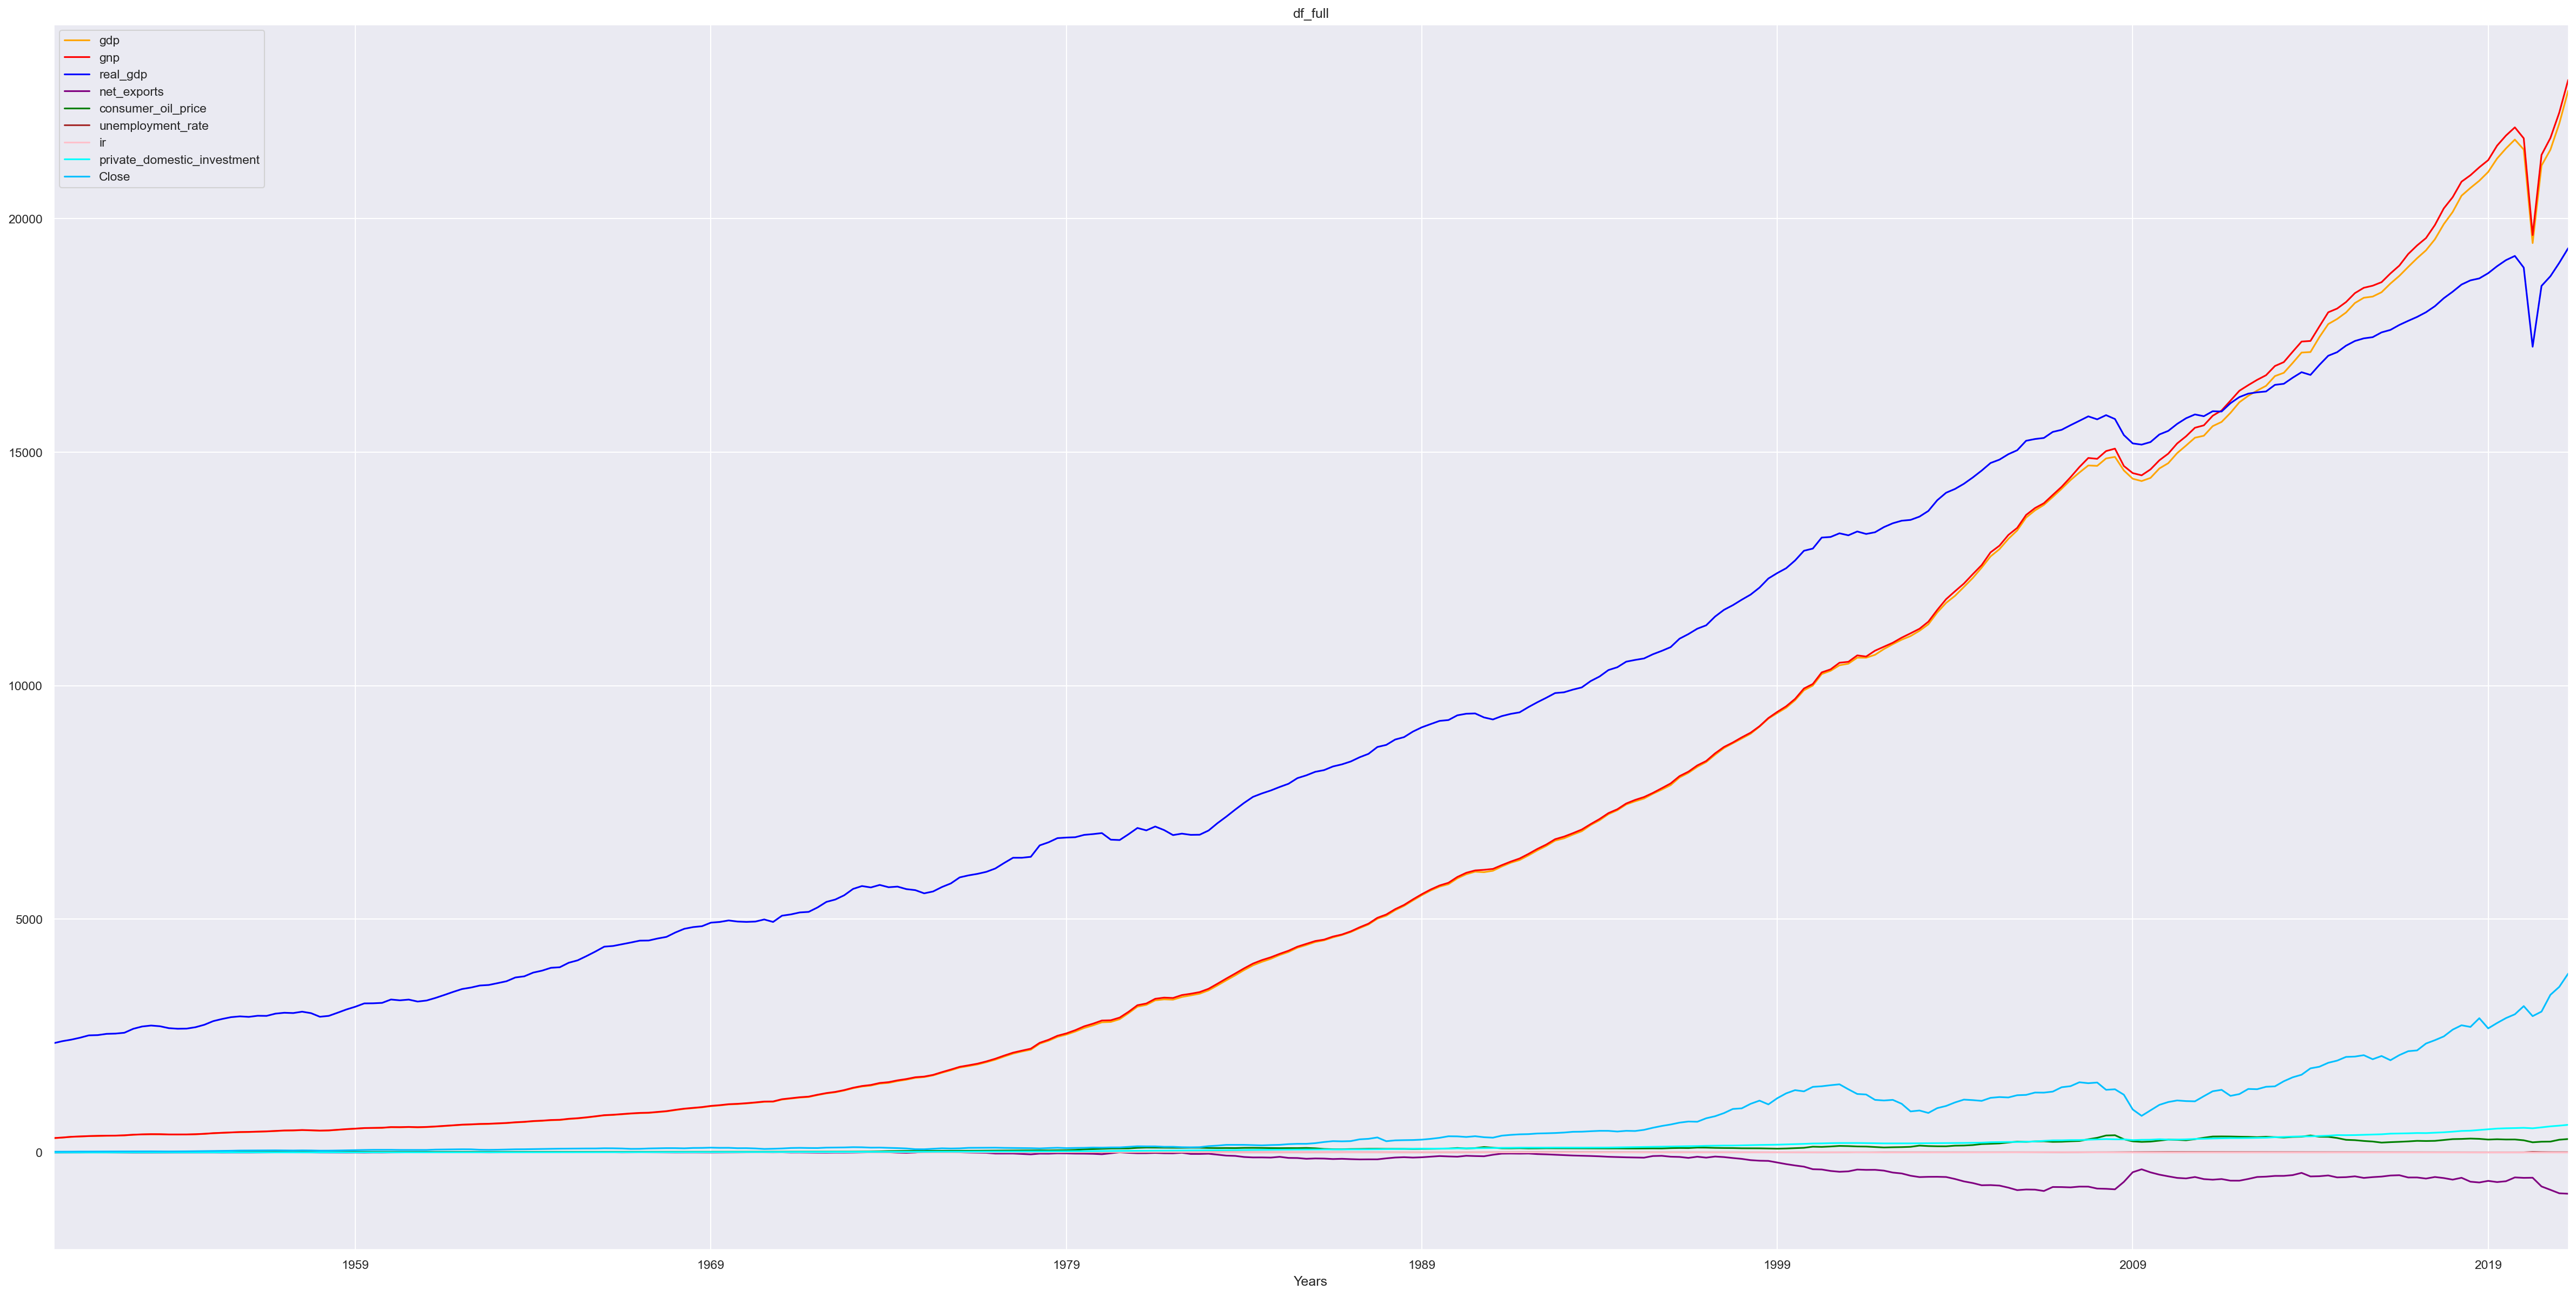

In [14]:
# to set the plot size
plt.figure(figsize=(40, 20), dpi=150)
  
# in plot method we set the label and color of the curve.
df_full['gdp'].plot(label='gdp', color='orange')
df_full['gnp'].plot(label='gnp', color='red')
df_full['real_gdp'].plot(label='real_gdp', color='blue')
# df_full['real_gdp_per_capita'].plot(label='real_gdp_per_capita', color='black')
df_full['net_exports'].plot(label='net_exports', color='purple')
df_full['consumer_oil_price'].plot(label='consumer_oil_price', color='green')
df_full['unemployment_rate'].plot(label='unemployment_rate', color='brown')
df_full['ir'].plot(label='ir', color='pink')
df_full['private_domestic_investment'].plot(label='private_domestic_investment', color='cyan')
df_full['Close'].plot(label='Close', color='deepskyblue')
  
# adding title to the plot
plt.title('df_full')
  
# adding Label to the x-axis
plt.xlabel('Years')
  
# adding legend to the curve
plt.legend()

<AxesSubplot:>

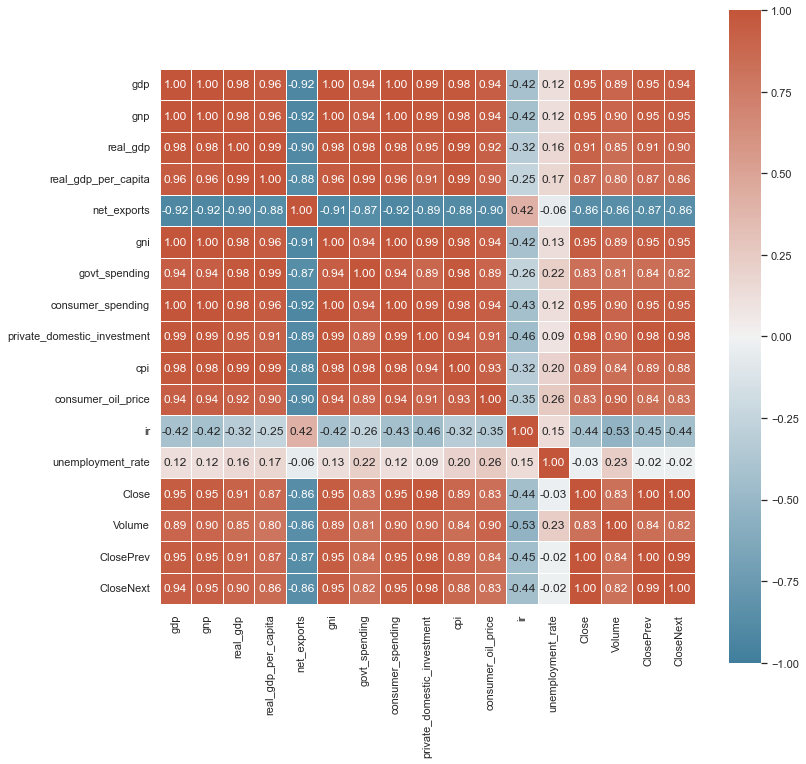

In [53]:
f, axes = plt.subplots(1,1,figsize=(12,12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_full.corr(), vmin=-1, vmax=1, cmap=cmap, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5)

# Analytic Visualization

## De-Trending

In [52]:
df_pct_change = pd.DataFrame()
for column in df_full:
    df_pct_change['%'+column] = df_full[column].pct_change()
df_pct_change = df_pct_change.dropna()

df_diff = pd.DataFrame()
for column in df_full:
    df_diff['DIFF_'+column] = df_full[column].diff()
df_diff = df_diff.dropna()

df_shift = df_full.shift(1)
df_lr = pd.DataFrame()
for column in df_full:
    df_lr['LR_'+column] = df_full[column].div(df_shift[column])
df_lr = df_lr.dropna()

df_full_new = pd.concat([df_full, df_pct_change, df_diff, df_lr], axis=1)
df_full_new = df_full_new.dropna()

corr = df_full_new.corr()
corr.to_csv("correlation..csv")
print("The Whole Correlation Matrix")
display(corr)

List = []
for i in range(17):
    Sum = abs(corr["%CloseNext"][17+i]) + abs(corr["DIFF_CloseNext"][34+i]) + abs(corr["LR_CloseNext"][51+i])
    avg = Sum/3
    List.append(avg)

corr = pd.DataFrame(corr["CloseNext"])
corr = corr.head(17)
corr["CloseNext (detrend)"] = List
#corr = corr.sort_values(by = 'CloseNext', key=abs, ascending=False)
print("All correlations to 'CloseNext'")
display(pd.DataFrame(corr.sort_values(by = 'CloseNext', key=abs, ascending=False)['CloseNext']))
print("\nAll correlations to 'CloseNext' after de-trending")
display(pd.DataFrame(corr.sort_values(by = 'CloseNext (detrend)', key=abs, ascending=False)['CloseNext (detrend)']))

The Whole Correlation Matrix


,gdp,gnp,real_gdp,real_gdp_per_capita,net_exports,gni,govt_spending,consumer_spending,private_domestic_investment,cpi,...,LR_consumer_spending,LR_private_domestic_investment,LR_cpi,LR_consumer_oil_price,LR_ir,LR_unemployment_rate,LR_Close,LR_Volume,LR_ClosePrev,LR_CloseNext
gdp,1.000000,0.999984,0.984531,0.960796,-0.917237,0.999866,0.943296,0.999779,0.986188,0.978617,...,-0.243836,-0.269005,-0.250519,-0.021556,-0.056381,0.036629,0.018873,-0.048824,0.009268,0.025642
gnp,0.999984,1.000000,0.983937,0.959826,-0.916641,0.999874,0.942230,0.999823,0.986571,0.977939,...,-0.243620,-0.268321,-0.250096,-0.021282,-0.055983,0.036232,0.019065,-0.049424,0.009422,0.025817
real_gdp,0.984531,0.983937,1.000000,0.994201,-0.904937,0.984321,0.982064,0.981935,0.949683,0.992527,...,-0.210208,-0.295425,-0.192296,0.002007,-0.051441,0.022345,0.006254,-0.037882,-0.001265,0.009370
real_gdp_per_capita,0.960796,0.959826,0.994201,1.000000,-0.882381,0.960622,0.990872,0.956553,0.914387,0.987958,...,-0.185000,-0.299301,-0.153054,0.015525,-0.048881,0.010913,0.002951,-0.031748,-0.002550,0.002476
net_exports,-0.917237,-0.916641,-0.904937,-0.882381,1.000000,-0.910600,-0.872842,-0.920515,-0.892082,-0.884643,...,0.207594,0.246261,0.231553,-0.066605,0.016236,-0.013455,0.013098,0.034038,0.016504,0.030954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LR_unemployment_rate,0.036629,0.036232,0.022345,0.010913,-0.013455,0.037451,0.042408,0.035396,0.067965,0.035546,...,-0.630669,-0.221115,-0.093444,-0.200346,-0.448152,1.000000,-0.214290,0.166371,-0.114507,-0.053700
LR_Close,0.018873,0.019065,0.006254,0.002951,0.013098,0.020119,-0.010354,0.017757,0.024251,0.021900,...,0.168481,0.118486,-0.076879,0.068194,0.189943,-0.214290,1.000000,0.159729,0.234349,0.237811
LR_Volume,-0.048824,-0.049424,-0.037882,-0.031748,0.034038,-0.049259,-0.026931,-0.050580,-0.048557,-0.037516,...,-0.051127,-0.124280,-0.031384,-0.110365,-0.152209,0.166371,0.159729,1.000000,-0.074328,0.051312
LR_ClosePrev,0.009268,0.009422,-0.001265,-0.002550,0.016504,0.010294,-0.021422,0.007078,0.013980,0.012575,...,0.018989,0.131264,-0.112704,0.039263,0.048924,-0.114507,0.234349,-0.074328,1.000000,0.035215


All correlations to 'CloseNext'


,CloseNext
CloseNext,1.000000
Close,0.997446
ClosePrev,0.994099
private_domestic_investment,0.978368
consumer_spending,0.945604
gni,0.945140
gnp,0.945078
gdp,0.944850
real_gdp,0.901008
cpi,0.882512



All correlations to 'CloseNext' after de-trending


,CloseNext (detrend)
CloseNext,1.000000
real_gdp,0.260004
Close,0.256138
real_gdp_per_capita,0.255362
consumer_spending,0.251089
gnp,0.241813
gdp,0.239260
gni,0.232550
private_domestic_investment,0.222579
net_exports,0.167888


# Machine Learning

## Select features based on correlation

<b>Highly correlated features to be ignored</b> - ClosePrev, Close, CloseNext<br />

<b>Features with highest correlation: (before de-trending)</b><br />
    - ['private_domestic_investment', 'consumer_spending', 'gni', 'gnp', 'gdp', 'real_gdp', 'cpi']              
<b>Features with highest correlation: (after de-trending)</b><br />
    - ['real_gdp', 'real_gdp_per_capita', 'consumer_spending', 'gnp', 'gdp', 'gni', 'private_domestic_investment']

## Select polynomial degree

In [34]:
y = pd.DataFrame(df_full['CloseNext'])
X = pd.DataFrame(df_full[['real_gdp', 'consumer_spending', 'gnp', 'gdp', 'private_domestic_investment']])

res_df2 = pd.DataFrame({'R^2':[], 'MSE train':[], 'MSE test':[]})

from sklearn.model_selection import train_test_split
from statistics import median
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

for i in range (1, 11):
    var = []
    mse_train = []
    mse_test = []
    for j in range (20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=j)

        poly = PolynomialFeatures(degree=i)
        poly_reg = LinearRegression()

        X_ = poly.fit_transform(X_train)
        X_ = np.delete(X_,(1),axis=1)
        poly_reg.fit(X_, y_train)
        y_pred = poly_reg.predict(X_)
        var.append(poly_reg.score(X_, y_train))

        X_2 = poly.fit_transform(X_test)
        X_2 = np.delete(X_2,(1),axis=1)
        y_pred2 = poly_reg.predict(X_2)
        
        mse_train.append(mse(y_train, y_pred))
        mse_test.append(mse(y_test, y_pred2))
    
    new_row = {'R^2':median(var), 'MSE train':median(mse_train), 'MSE test':median(mse_test)}
    res_df2 = res_df2.append(new_row, ignore_index=True)

res_df2.index += 1
res_df2.index.name = 'polynomial degree'
display(res_df2)

,R^2,MSE train,MSE test
polynomial degree,,,
1,0.979422,14526.652740,1.582825e+04
2,0.995753,3000.218325,5.905086e+03
3,0.998484,986.443388,2.092450e+04
4,0.999657,257.672579,4.069586e+06
5,0.999958,30.474311,1.009921e+09
6,0.999960,27.153904,7.782842e+09
7,0.999958,27.447348,2.570663e+11
8,0.999963,25.501898,7.066372e+11
9,0.999953,31.855104,7.643811e+12


As above, the lowest MSE (from test set) is achieved at polynomial degree 2.<br/>
Beyond degree 2, we see <b>overfitting</b>.

## Obtain Samples

In [35]:
# get median MSE (for train set) for degree 2
trials_n = 1001 # no. of trials 

res_df2 = pd.DataFrame({'R^2':[], 'MSE train':[], 'MSE test':[]})

from sklearn.model_selection import train_test_split
for i in range (trials_n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=i)

    poly = PolynomialFeatures(degree=2)
    poly_reg = LinearRegression()
    
    X_ = poly.fit_transform(X_train)
    X_ = np.delete(X_,(1),axis=1)
    poly_reg.fit(X_, y_train)
    y_pred = poly_reg.predict(X_)
    var = poly_reg.score(X_, y_train)
    
    X_2 = poly.fit_transform(X_test)
    X_2 = np.delete(X_2,(1),axis=1)
    y_pred2 = poly_reg.predict(X_2)
    
    new_row = {'R^2':var, 'MSE train':mse(y_train, y_pred), 'MSE test':mse(y_test, y_pred2)}
    res_df2 = res_df2.append(new_row, ignore_index=True)

res_df2.index.name = 'random_state'
print("Values before removing outliers:")
display(res_df2)
display(res_df2.describe())

q1_var = res_df2.describe().loc['25%'].at['R^2']
q3_var = res_df2.describe().loc['75%'].at['R^2']
iqr_var = q3_var - q1_var

q1_MSE = res_df2.describe().loc['25%'].at['MSE train']
q3_MSE = res_df2.describe().loc['75%'].at['MSE train']
iqr_MSE = q3_MSE - q1_MSE

q1_test = res_df2.describe().loc['25%'].at['MSE test']
q3_test = res_df2.describe().loc['75%'].at['MSE test']
iqr_test = q3_test - q1_test

state = res_df2[(res_df2['R^2'] >= q1_var-1.5*iqr_var) & (res_df2['R^2'] <= q3_var+1.5*iqr_var)
               & (res_df2['MSE train'] >= q1_MSE-1.5*iqr_MSE) & (res_df2['MSE train'] <= q3_MSE+1.5*iqr_MSE)
              & (res_df2['MSE test'] >= q1_test-1.5*iqr_test) & (res_df2['MSE test'] <= q3_test+1.5*iqr_test)].index.tolist()
res_df2 = res_df2.iloc[state]
print("Remaining values after removing outliers:")
display(res_df2)
display(res_df2.describe())

res_df2.to_csv('regression_results.csv')

Values before removing outliers:


,R^2,MSE train,MSE test
random_state,,,
0,0.995990,2994.527638,5650.010434
1,0.994897,3065.568615,9387.281339
2,0.995635,3005.909011,4589.438490
3,0.995097,3285.241116,4903.423473
4,0.995057,3060.667572,18905.427994
...,...,...,...
996,0.996128,3010.289085,4610.154781
997,0.996250,2972.206695,4543.214138
998,0.995662,3118.203146,4294.546850


,R^2,MSE train,MSE test
count,1001.000000,1001.000000,1001.000000
mean,0.995626,3026.953289,6973.776665
std,0.000416,275.057484,12357.353539
min,0.994217,1931.048283,2140.849002
25%,0.995360,2847.228264,4345.412785
50%,0.995640,3040.760171,5348.256360
75%,0.995912,3215.230376,6817.772606
max,0.996976,3725.859807,259940.695722


Remaining values after removing outliers:


,R^2,MSE train,MSE test
random_state,,,
0,0.995990,2994.527638,5650.010434
1,0.994897,3065.568615,9387.281339
2,0.995635,3005.909011,4589.438490
3,0.995097,3285.241116,4903.423473
5,0.995964,2792.589563,5233.713568
...,...,...,...
996,0.996128,3010.289085,4610.154781
997,0.996250,2972.206695,4543.214138
998,0.995662,3118.203146,4294.546850


,R^2,MSE train,MSE test
count,915.000000,915.000000,915.000000
mean,0.995628,3052.488652,5462.795298
std,0.000390,250.738428,1630.392108
min,0.994540,2317.738661,2140.849002
25%,0.995366,2882.763784,4277.721706
50%,0.995639,3058.854563,5216.214517
75%,0.995902,3221.948141,6368.133108
max,0.996699,3725.859807,10508.262169


## Visualize Median Test Results (with error bars)

In [36]:
# Find best train-test-split based on median R^2 or MSE
option = 'MSE' # 'R^2' or 'MSE' ('MSE' refers to 'MSE train')

med = 0
state = 0
if (option == 'R^2'):
    med = res_df2.describe().loc['50%'].at['R^2']
    state = res_df2['R^2'].sub(med).abs().idxmin()
elif (option == 'MSE'):
    med = res_df2.describe().loc['50%'].at['MSE train']
    state = res_df2['MSE train'].sub(med).abs().idxmin()
print(f'random_state = {state}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=state)

poly = PolynomialFeatures(degree=2)
poly_reg = LinearRegression()

# train model
X_ = poly.fit_transform(X_train)
X_ = np.delete(X_,(1),axis=1)
poly_reg.fit(X_, y_train)
y_pred = poly_reg.predict(X_)
# test model
X_2 = poly.fit_transform(X_test)
X_2 = np.delete(X_2,(1),axis=1)
y_pred2 = poly_reg.predict(X_2)
# whole model (train+test)
X_3 = poly.fit_transform(X)
X_3 = np.delete(X_3,(1),axis=1)
y_pred3 = poly_reg.predict(X_3)

print(f'Explained Variance: {poly_reg.score(X_, y_train)}')
print(f'Train Set MSE: {mse(y_train, y_pred)}')
print(f'Test Set MSE: {mse(y_test, y_pred2)}')

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_full.index, y=y['CloseNext'], name="Actual Price"))

#fig.add_trace(go.Scatter(x=y.index, y=pd.Series(np.squeeze(y_pred3)), name="Predicted Price (TRAIN + TEST)"))

error = np.array(y_test) - np.array(y_pred2)
fig.add_trace(go.Scatter(
        x=y_test.index, y=pd.Series(np.squeeze(y_pred2)),
        error_y=dict(
            type='data',
            symmetric=False,
            array=error,
            visible=True),
        mode='markers',
        name="Predicted Price (TEST)"))

fig.update_layout(
    title_text='### Mean Square Error :' + str(mse(y_test, y_pred2).round(2)) + ' ###'
)

fig.update_xaxes(title_text="<b>Date</b>")
fig.update_yaxes(title_text="<b>Price</b>")

fig.show()

random_state = 133
Explained Variance: 0.9958813821709364
Train Set MSE: 3058.8545630385765
Test Set MSE: 4694.10972128182


In [37]:
display(poly_reg.coef_)
display(poly_reg.intercept_)

array([[ 0.00000000e+00, -4.82740777e+00,  3.11238007e+01,
        -2.93861763e+01,  5.57739589e+01,  4.31052795e-06,
         8.63905246e-04, -5.96606814e-03,  5.60799706e-03,
        -7.67383699e-03, -2.85729284e-03,  1.63180369e-02,
        -1.40565702e-02,  3.82623389e-02, -1.26676021e-02,
         2.02297299e-02, -7.40590789e-02, -7.95928468e-03,
         5.51038419e-02, -3.30868050e-02]])

array([177.73111166])

# Statistical inference

## Hypothesis Testing

In [42]:
reg_df = pd.read_csv("regression_results.csv")
reg = reg_df['MSE test']
lstm = pd.read_csv("lstm_results.csv")
lstm.drop('Unnamed: 0', inplace=True, axis=1)
from scipy import stats
stats.ttest_ind(reg, lstm, equal_var = False)

Ttest_indResult(statistic=array([-8.88166578]), pvalue=array([1.32065667e-07]))

Let h0= "both means are equal", h1= "lstm mean is higher than reg", p value of test statistic is 1.32065667e-07, so at a 99% confidence interval we reject the null hypothesis.